<a href="https://colab.research.google.com/github/MissTiny/Graph_Mining_Node_Edge_K-Mean_Clustering/blob/main/GA_K_means_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports.

In [51]:
import json
import numpy as np
import pandas as pd
import networkx as nx

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
import math
import copy
from multiprocessing import Pool
import import_ipynb
from ipynb.fs.full.parallel_functions import parallel_insider_algorithm2_part2

Reading Signed network.

In [2]:
signed_network = nx.read_weighted_edgelist('soc-sign-Slashdot090221.txt.gz', comments='#', create_using=nx.DiGraph(), nodetype = int)

Reading node features.

In [3]:
node_features ={}
no_of_features = 100
line_no = 0
with open("embedded-soc-sign-slashdot") as nf: 
    Lines = nf.readlines() 
    for line in Lines:
        #skip first line
        if line_no > 0:
            # splitting by space
            values = line.split()
            values = values[:no_of_features+1]
            index = 0
            # reading node features
            for val in values:
                if index == 0:
                    # reading nodeIds for first time
                    if line_no == 1:
                        node_features["nodeId"] = [int(val)]
                    else:
                        node_features["nodeId"].append(int(val))
                
                elif index > 0:
                    # reading features for the first time
                    if line_no == 1:
                        node_features["feature"+str(index)] = [float(val)]
                    else:
                        node_features["feature"+str(index)].append(float(val))
                index+=1
        line_no += 1

node_features_df = pd.DataFrame(node_features)

Determining optimal number of clusters or number of active centers using elbow method.

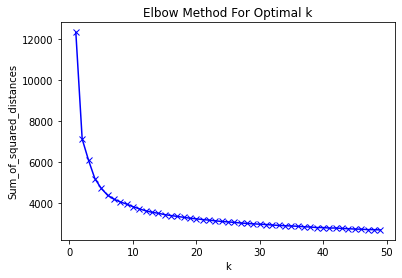

In [4]:
# To give equal importance to all features, we need to scale the continuous features. 
# We will be using scikit-learn’s MinMaxScaler as the feature matrix is a mix of binary and continuous features . 
mms = MinMaxScaler()
mms.fit(node_features_df)
node_features_df_transformed = mms.transform(node_features_df)

Sum_of_squared_distances = []
K = range(1,50)
for k in K:
    km = KMeans(n_clusters=k, n_jobs=-1)
    km = km.fit(node_features_df_transformed)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

From above elbow plot, it looks like optimal value of K is 7.

In [4]:
K = 7

Extracting k active centers.

In [5]:
nodeIds = list(node_features_df["nodeId"])

Calculating profile similarities

In [6]:
# based on euclidean distance
def profSimilarity(nodeId, active_center, active_centers):
    
    nodeId_index = nodeIds.index(nodeId)
    ac_index = active_centers.index(active_center)
    # setting to 1 to avoid division by zero error
    sum = 1
    for i in range(0, no_of_features):
        
        sq_diff = (node_features_df["feature"+str(i+1)][nodeId_index] - node_features_df["feature"+str(i+1)][ac_index])**2
        sum += sq_diff

    # returning inverse as high value means less similarity.
    return 1/math.sqrt(sum)

Calculating edge exists or not

In [7]:
def edgeExists(nodeId, active_center):
    if signed_network.has_edge(nodeId, active_center) or signed_network.has_edge(active_center, nodeId):
        return 1
    else:
        return 0

Calculating strength of Ties

In [8]:
def strengthOfTies(nodeId, active_center):
    sum = 0
    for degree in list(dict(signed_network.degree([nodeId, active_center])).values()):
        sum+=degree
    sum -= 1
    return 1/sum

Calculating degree centrality

In [9]:
def degreeCentrality(x,circle):
    degree = 0
    for c in circle:
        if signed_network.has_edge(x, c) or signed_network.has_edge(c, x):
            degree+=1
    # error if len(circle) = 1
    if len(circle) ==1:
        deg_cen = degree
    else:
        deg_cen = degree/(len(circle)-1)
    return deg_cen

finding residual area

In [10]:
def residualArea(x,circle):
    residual = list(signed_network.neighbors(x))
    for re in residual:
        if re in circle:
            residual.remove(re)
    return residual
        

#### No need for the following cell, it is rewrited into algorithm 1 for further use
Social Circle Generation using K-means.
Removing active_centers.

## Algorithm 1

In [11]:
def algorithm1(nodeIds,active_centers):
    social_circles = {}
    nodeIdsWAC = list(set(nodeIds) - set(active_centers))
    for i in range (0, K):
        active_center = active_centers[i]
        social_circles[str(active_center)] = []
    for nodeId in nodeIdsWAC:
        maxS = 0
        # active_center which will be most similar to given node
        selectedAC = -1
        for i in range (0, K):
            active_center = active_centers[i]
            p1 = 0
            p2 = 0
            p3 = 0

            p1 = edgeExists(nodeId, active_center)

            if p1 == 1:
                p2 = profSimilarity(nodeId, active_center,active_centers)
                p3 = strengthOfTies(nodeId, active_center)

                if maxS < p2 + p3:
                    maxS = p2 + p3
                    selectedAC = active_center
    
        if selectedAC != -1:
            social_circles[str(selectedAC)].append(nodeId)
    return social_circles

In [12]:
#center selection
##population size = 40
N = 40
population = []
random.seed(0)

In [13]:
for i in range(0,N):
    selected = random.sample(nodeIds,K)
    if selected not in population:
        population.append(selected)


In [14]:
#initialize n=1 and fitness = 0

fitness=[]
for n in range(0,N):
    #pick up the ith row from X_ij and Cij
    Xi = population[n]
    Cij = algorithm1(nodeIds,Xi)
    
    obj=0
    for k in range(0,K):
        #initialize k=1 and obj=0
        xi = Xi[k]
        
        residual =  residualArea(xi,Cij[str(xi)])
        #deg_cen
        deg_cen_C = degreeCentrality(xi,Cij[str(xi)])
        deg_cen_R = degreeCentrality(xi,residual)
        
        #prof_sim
        prof_sim_C = 0
        for c in Cij[str(xi)]:
            prof_sim_C+=profSimilarity(c, xi,Xi)
        prof_sim_C = prof_sim_C/len(Cij)
        
        prof_sim_R = 0
        for r in residual:
            prof_sim_R+=profSimilarity(r, xi,Xi)
        if len(residual) != 0:
            prof_sim_R = prof_sim_R/len(residual)
        
        #str_C
        str_C = 0
        for c in Cij[str(xi)]:
            str_C+= strengthOfTies(c, xi)
        str_C = str_C/len(Cij)
        
        str_R = 0
        for r in residual:
            str_R+= strengthOfTies(r, xi)
        if len(residual) != 0:
             str_R = str_R/len(residual)
       
        
        obj+=deg_cen_C - deg_cen_R + prof_sim_C - prof_sim_R + str_C - str_R
    
    fitness.append(obj/K)    
        

### Algorithm2_part1 takes one group of centers and return the fitness of it

In [15]:
def algorithm2_part1(pop_n):
    Xi = pop_n
    Cij = algorithm1(nodeIds,Xi)
    
    obj=0
    for k in range(0,K):
        #initialize k=1 and obj=0
        xi = Xi[k]
        
        residual =  residualArea(xi,Cij[str(xi)])
        #deg_cen
        deg_cen_C = degreeCentrality(xi,Cij[str(xi)])
        deg_cen_R = degreeCentrality(xi,residual)
        
        #prof_sim
        prof_sim_C = 0
        for c in Cij[str(xi)]:
            prof_sim_C+=profSimilarity(c, xi,Xi)
        prof_sim_C = prof_sim_C/len(Cij)
        
        prof_sim_R = 0
        for r in residual:
            prof_sim_R+=profSimilarity(r, xi,Xi)
        if len(residual) != 0:
            prof_sim_R = prof_sim_R/len(residual)
        
        #str_C
        str_C = 0
        for c in Cij[str(xi)]:
            str_C+= strengthOfTies(c, xi)
        str_C = str_C/len(Cij)
        
        str_R = 0
        for r in residual:
            str_R+= strengthOfTies(r, xi)
        if len(residual) != 0:
             str_R = str_R/len(residual)
       
        
        obj+=deg_cen_C - deg_cen_R + prof_sim_C - prof_sim_R + str_C - str_R
    
    
    return obj/K

#### Functions to check the format of generated Q offspring

In [ ]:
def check(matrix):
    for i in matrix:
        if len(i)!=8:
            print("error in row: ",i)

## Main Function

In [56]:
# Part two
##Augmented matrix Q
Q=[]
for i in range(0,len(fitness)):
    Qi = population[i].copy()
    Qi.append(fitness[i])
    Q.append(Qi)

In [57]:
# re-sort in descending order
Q_desc= sorted(Q,key=lambda x:x[K],reverse=True)

In [61]:
iteration = 0
Q_desc_new=[]
pre_fit = 0

while iteration <10:
    if (Q_desc_new != []):
        Q_desc = Q_desc_new
        pre_fit = Q_desc[0][-1]
        Q_desc_new = []
        
    for i in range(0,N):
        print(i)
        #Select two parant chromosomes let say X1 and X2 from a population with high fitness value
        #########This trunk try to find the best X after crossover###################################################
        #assume fitness value > 1 means high
        Q_high = list(filter(lambda x:x[K]>1,Q_desc))
        if len(Q_high) >10:
            Q_high = Q_high[:10]
        
        #print(Q_high)
        Q1 = random.choice(Q_high)
        Q2 = random.choice(Q_high)
        #print(Q1,Q2)
        x1 = Q1[:-1]
        x1_fit = Q1[-1]
        x2 = Q2[:-1]
        x2_fit = Q2[-1]
        while x2 == x1:
            x2 = random.choice(Q_high)
        #random.seed(0)
        randc_pos = random.randint(1,K)
        
        x1_new = x1[:randc_pos]+x2[randc_pos:]
        x2_new = x2[:randc_pos]+x1[randc_pos:]
        
        x1_new_fit = algorithm2_part1(x1_new)
        x2_new_fit = algorithm2_part1(x2_new)
        
        max_fit = max(x1_fit,x2_fit,x1_new_fit,x2_new_fit)
        
        if(x1_fit == max_fit):
            x = x1
            #print("x1 is the best")
        elif (x2_fit == max_fit):
            x = x2
            #print("x2 is the best")
        elif (x1_new_fit == max_fit):
            x = x1_new
            #print("x1 new is the best")
        else:
            x = x2_new
            #print("x2 new is the best")
###################original thought###################################        
#         x1 = Q_desc[i][:-1]
#         x2 = Q_desc[i+1][:-1]
        
#         #cross over
#         #generate a random int randc_pos
#         random.seed(0)
#         randc_pos = randint(1,K)
        
#         x1_new = x1[:randc_pos]+x2[randc_pos:]
#         x2_new = x2[:randc_pos]+x1[randc_pos:]
#########################################################
        #mutation
        #generate a random position randm_pos [1,k] and rand_id [1,n]
        randm_pos = random.randint(1,K)
        rand_id = random.choice(nodeIds)
        
        #x = x1_new
        #x = Q_desc[i]
        #repair chomorosome if values of two alleles of a chromosome occurs
        if rand_id in (x[:randm_pos-1]+x[randm_pos:]):
            x_new =x
        else:
            x_new = x[:randm_pos-1]+[rand_id]+x[randm_pos:]
        
        x_new_fit = algorithm2_part1(x_new)
        print("This is x_new_fit:", str(x_new_fit),"This is Q_desc[i][-1]",str(Q_desc[i][-1]))
        if (x_new_fit > Q_desc[i][-1]):
            Q_desc_new.append(x_new + [x_new_fit])
            #print("new Q is better")
        else:
            Q_desc_new.append(Q_desc[i])

    Q_desc_new= sorted(Q_desc_new,key=lambda x:x[-1],reverse=True)
    check(Q_desc_new)
    print(Q_desc_new)
    if Q_desc_new[0][-1] == pre_fit:
        iteration +=1
    else:
        iteration = 1
    print("Best fit is ",str(Q_desc_new[0][-1]),", and iteration currently is ", str(iteration))
        

0
This is x_new_fit: 1.608961333508748 This is Q_desc[i][-1] 1.6734156360667374
1
This is x_new_fit: 1.6704605351662618 This is Q_desc[i][-1] 1.635372799029864
2
This is x_new_fit: 1.5029675726429201 This is Q_desc[i][-1] 1.5458311390612285
3
This is x_new_fit: 1.2160712590662652 This is Q_desc[i][-1] 1.5304781609188203
4
This is x_new_fit: 1.3677757401013284 This is Q_desc[i][-1] 1.4896035711818476
5
This is x_new_fit: 1.7861048471530065 This is Q_desc[i][-1] 1.4813427416936555
6
This is x_new_fit: 1.2115853168501334 This is Q_desc[i][-1] 1.4705026026214862
7
This is x_new_fit: 1.4768788451382193 This is Q_desc[i][-1] 1.4593838595009974
8
This is x_new_fit: 1.6278813397775214 This is Q_desc[i][-1] 1.4431594996913832
9
This is x_new_fit: 1.4089246354101737 This is Q_desc[i][-1] 1.4347462440655876
10
This is x_new_fit: 1.4701655261381912 This is Q_desc[i][-1] 1.4015185607463898
11
This is x_new_fit: 1.637737598608153 This is Q_desc[i][-1] 1.3866291598771283
12
This is x_new_fit: 1.58740

This is x_new_fit: 1.81805838605667 This is Q_desc[i][-1] 1.4646744134918426
28
This is x_new_fit: 1.3685777487263717 This is Q_desc[i][-1] 1.4577880750088155
29
This is x_new_fit: 1.5743232218690923 This is Q_desc[i][-1] 1.442783991307887
30
This is x_new_fit: 1.4794219720582453 This is Q_desc[i][-1] 1.4347462440655876
31
This is x_new_fit: 1.588412778711182 This is Q_desc[i][-1] 1.4161078007357337
32
This is x_new_fit: 1.720394033380632 This is Q_desc[i][-1] 1.4152087608244095
33
This is x_new_fit: 1.8936643340333759 This is Q_desc[i][-1] 1.4126297698649377
34
This is x_new_fit: 1.6788257914497209 This is Q_desc[i][-1] 1.3862089290185433
35
This is x_new_fit: 1.5988447575705926 This is Q_desc[i][-1] 1.3817616376387847
36
This is x_new_fit: 1.6685737591998164 This is Q_desc[i][-1] 1.381387474493372
37
This is x_new_fit: 1.3680985773637868 This is Q_desc[i][-1] 1.3716654401336785
38
This is x_new_fit: 1.6767708777380814 This is Q_desc[i][-1] 1.3709957351388884
39
This is x_new_fit: 1.5

KeyboardInterrupt: 

### Following are attempts for parallel, please ignore them